# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals ✅
- Patches ✅
- Injective Neural Network as a data generating process ✅

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly


Additionally, we want to take an orthogonal transformation and check that the loss in our sampling experiment is higher than the loss we have achieved by directly optimizing the neural network $f$

In [13]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2000
kappa = tau = 8
iterations = 2000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

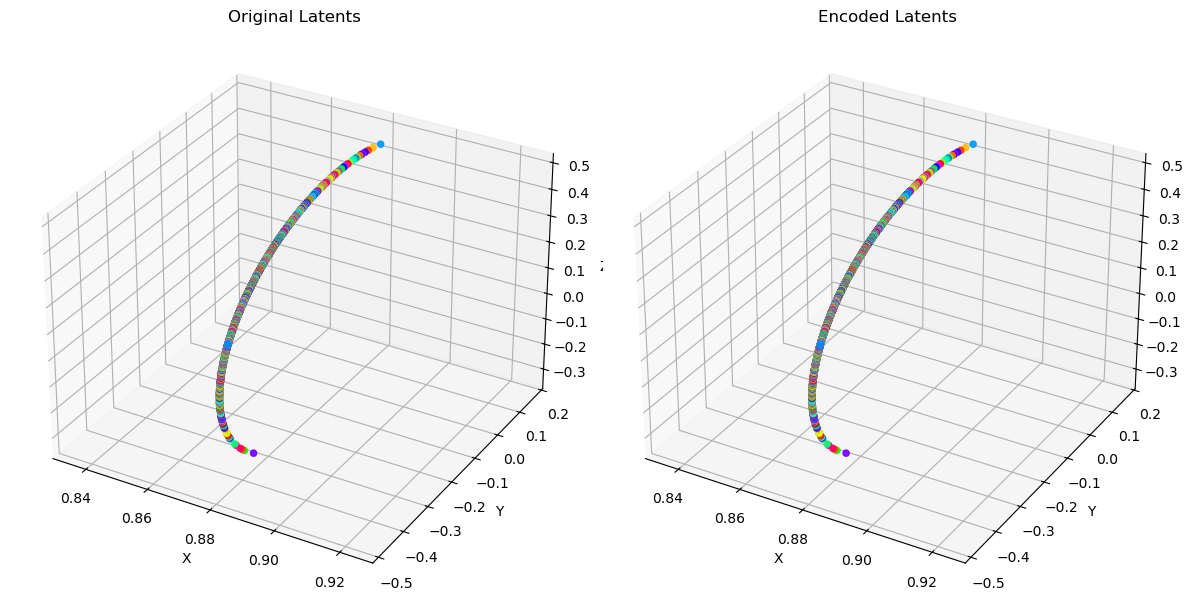

In [14]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601368427276611 Samples processed: 1 linear disentanglement: 0.4130331575870514 permutation disentanglement: 7.91947022662498e-05
Loss: 7.596576690673828 Samples processed: 21 linear disentanglement: 0.6266224384307861 permutation disentanglement: 0.025186637416481972
Loss: 7.549758434295654 Samples processed: 41 linear disentanglement: 0.5568540692329407 permutation disentanglement: 0.06739664077758789
Loss: 7.502714157104492 Samples processed: 61 linear disentanglement: 0.5379201769828796 permutation disentanglement: 0.1338290572166443
Loss: 7.497766017913818 Samples processed: 81 linear disentanglement: 0.4844196140766144 permutation disentanglement: 0.12901411950588226
Loss: 7.490536212921143 Samples processed: 101 linear disentanglement: 0.537388265132904 permutation disentanglement: 0.12557268142700195
Loss: 7.48696231842041 Samples processed: 121 linear disentanglement: 0.5739619731903076 permutation disentanglemen

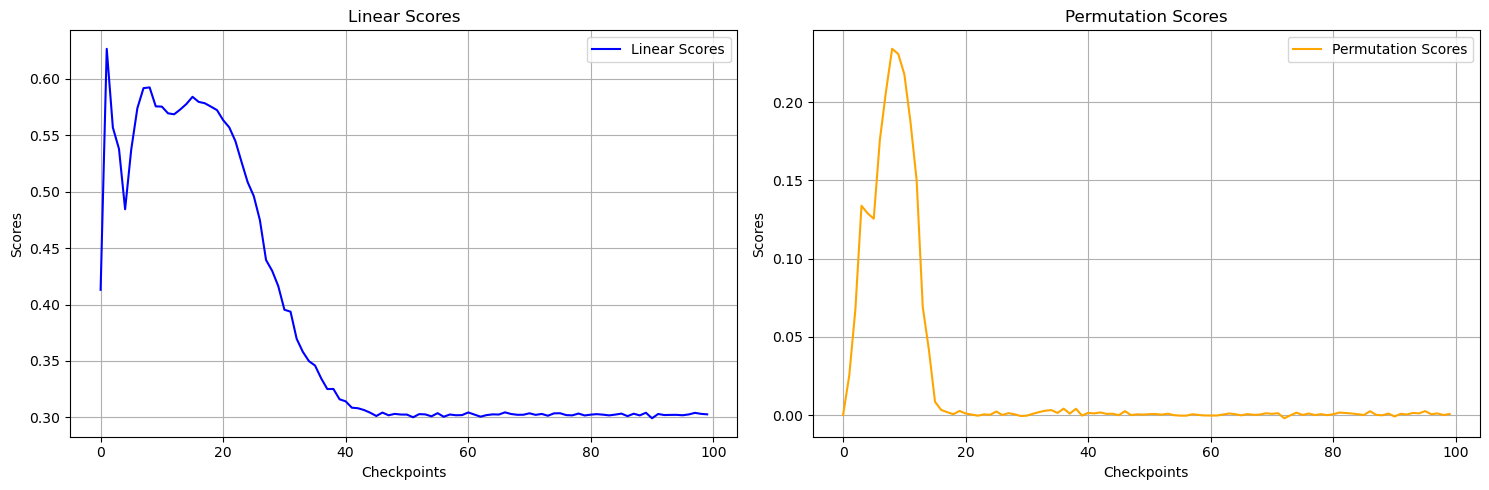

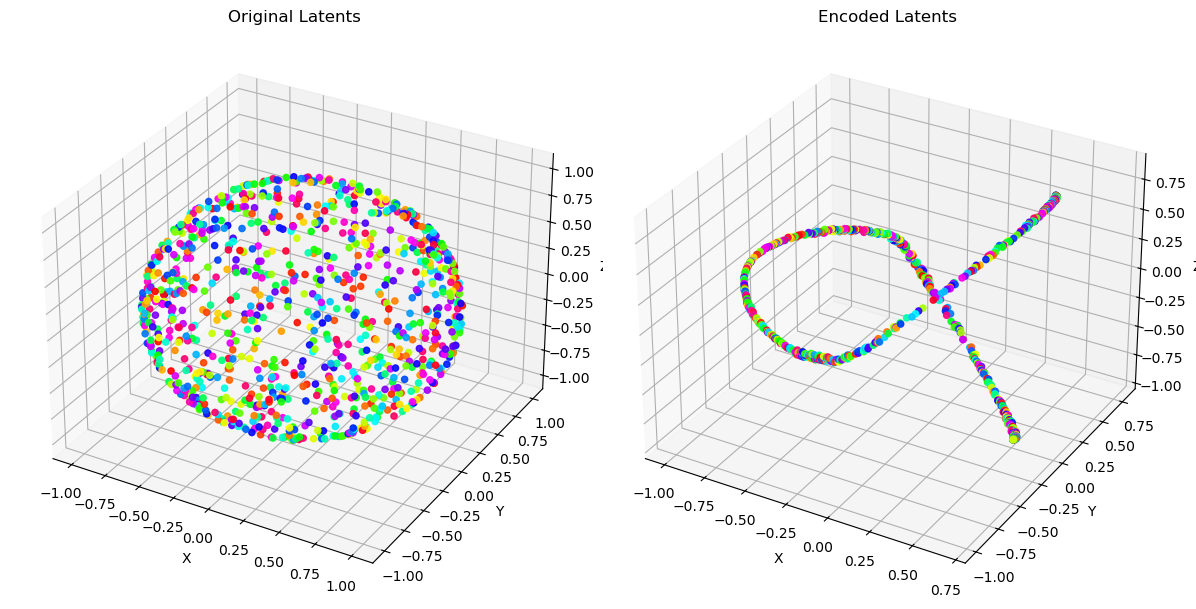

In [15]:
from visualization_utils.scoring import plot_scores

# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

simclr_id = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained, scores = simclr_id.train(batch_size, iterations)

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [ ]:
def compute_orthogonal_transformation_loss(sample_joint, sample_marginal):
    z, z_aug = sample_joint(batch_size)

    # (N, N, 3)
    z_neg = torch.nn.functional.normalize(
        torch.randn((batch_size, batch_size, latent_dim), device=z.device), p=2, dim=-1)

    pos = - torch.sum(z * z_aug, dim=-1).mean() / tau
    
    # (N, 1, 3) * (N, N, 3) -> (N, N, 3)
    neg = torch.log(torch.exp((z.unsqueeze(1) * z_neg).sum(dim=-1) / tau).sum(-1)).mean()

    return pos + neg


orthogonal_loss = compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)
training_loss = 7.479090213775635 # TODO: just for testing now

print("Orthogonal transformation loss: ", orthogonal_loss.item())
print("Training loss: ", training_loss)


Orthogonal transformation loss:  7.483778476715088
Training loss:  7.479090213775635


## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601358413696289 Samples processed: 1 linear disentanglement: 0.45517006516456604 permutation disentanglement: 0.00023686885833740234
Loss: 7.596076011657715 Samples processed: 21 linear disentanglement: 0.4420642852783203 permutation disentanglement: 0.016746878623962402
Loss: 7.551321506500244 Samples processed: 41 linear disentanglement: 0.39382365345954895 permutation disentanglement: 0.13157527148723602
Loss: 7.494940757751465 Samples processed: 61 linear disentanglement: 0.3747163712978363 permutation disentanglement: 0.24367393553256989
Loss: 7.491816997528076 Samples processed: 81 linear disentanglement: 0.29533347487449646 permutation disentanglement: 0.22153134644031525
Loss: 7.490537643432617 Samples processed: 101 linear disentanglement: 0.3193868100643158 permutation disentanglement: 0.22744403779506683
Loss: 7.48838996887207 Samples processed: 121 linear disentanglement: 0.3384076654911041 permutation disenta

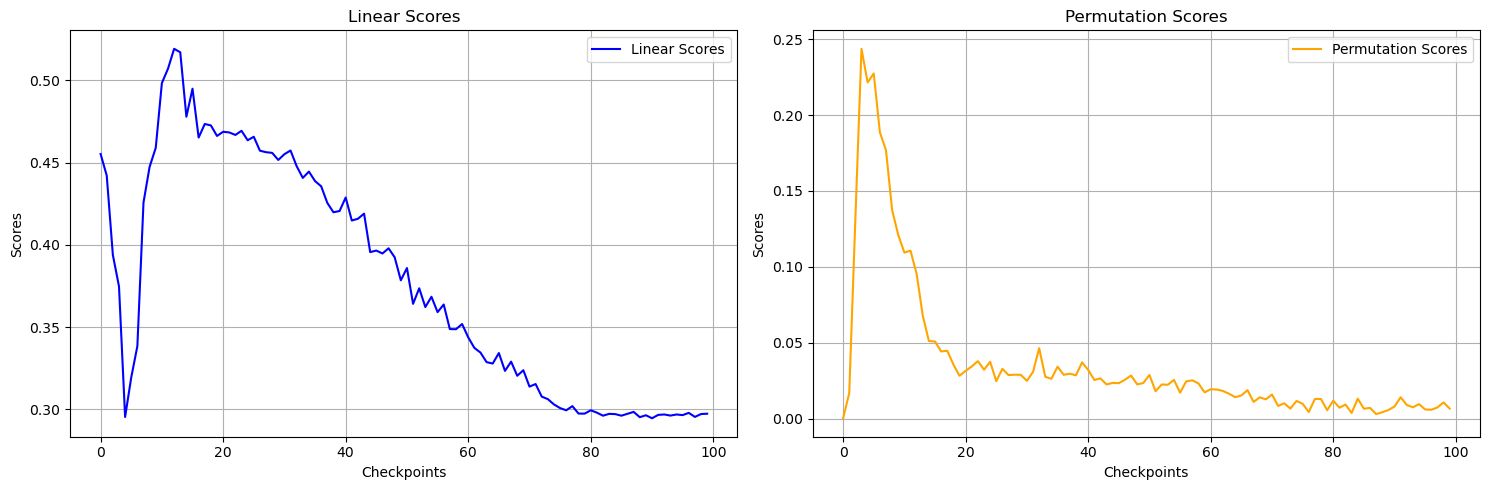

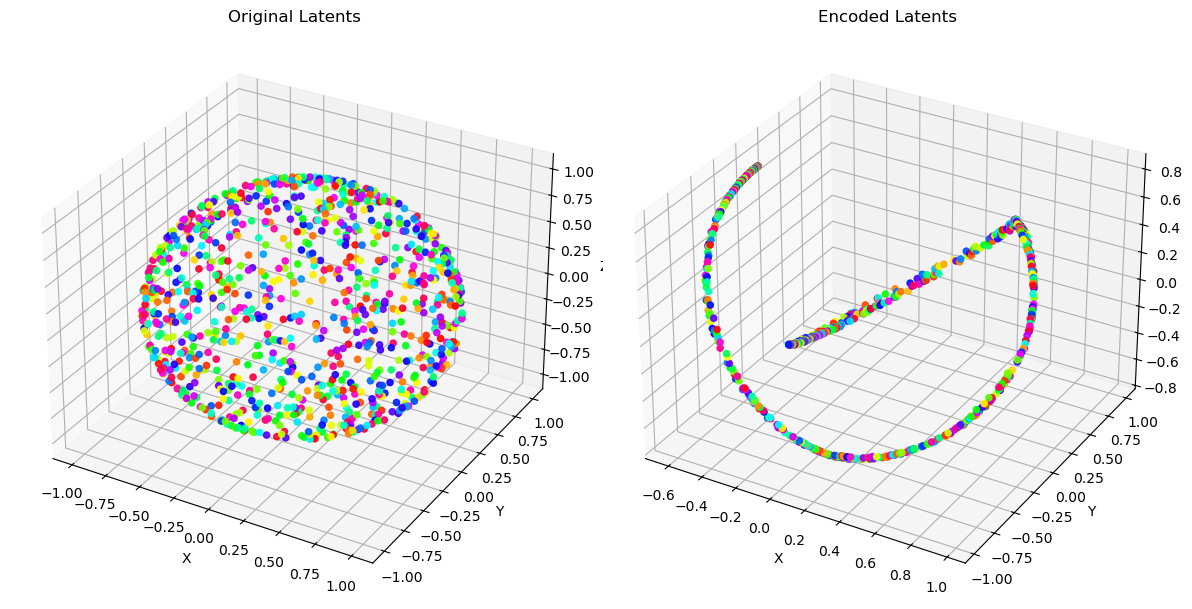

In [16]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    4, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [7]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4838)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.6012163162231445 Samples processed: 1 linear disentanglement: 0.4092356860637665 permutation disentanglement: 0.006282051559537649
Loss: 7.573099136352539 Samples processed: 21 linear disentanglement: 0.4841158390045166 permutation disentanglement: 0.1532958745956421
Loss: 7.50160551071167 Samples processed: 41 linear disentanglement: 0.3152899444103241 permutation disentanglement: 0.1351541429758072
Loss: 7.495572090148926 Samples processed: 61 linear disentanglement: 0.4240140914916992 permutation disentanglement: 0.13086867332458496
Loss: 7.491817951202393 Samples processed: 81 linear disentanglement: 0.48573434352874756 permutation disentanglement: 0.11521121114492416
Loss: 7.488498210906982 Samples processed: 101 linear disentanglement: 0.5807907581329346 permutation disentanglement: 0.04790997505187988
Loss: 7.486497402191162 Samples processed: 121 linear disentanglement: 0.6271834373474121 permutation disentangleme

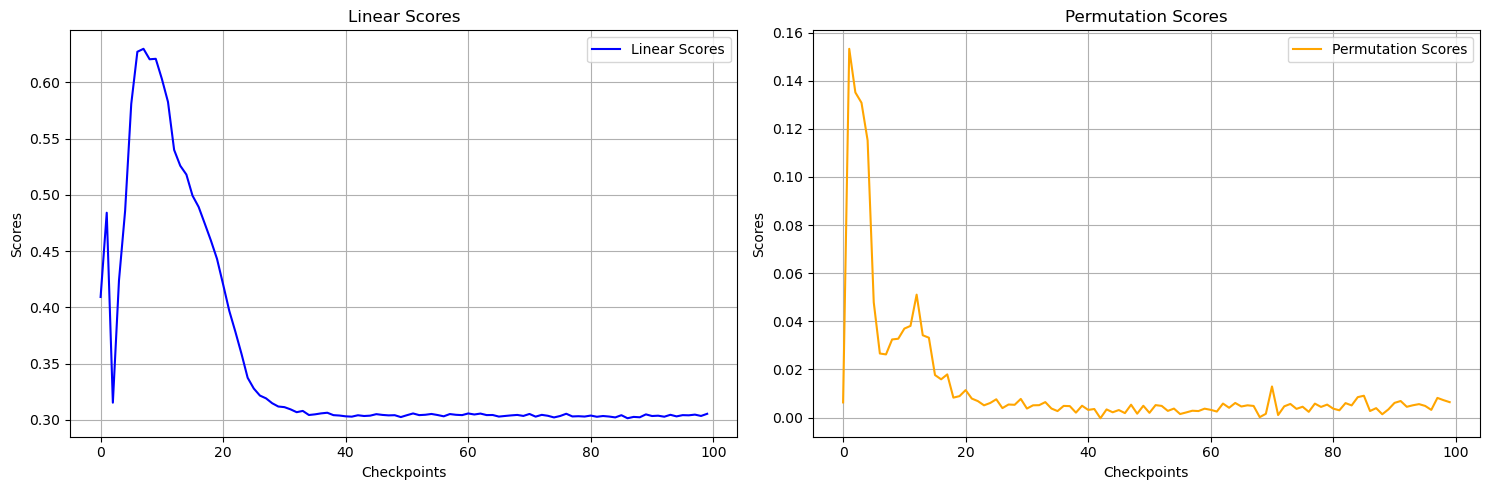

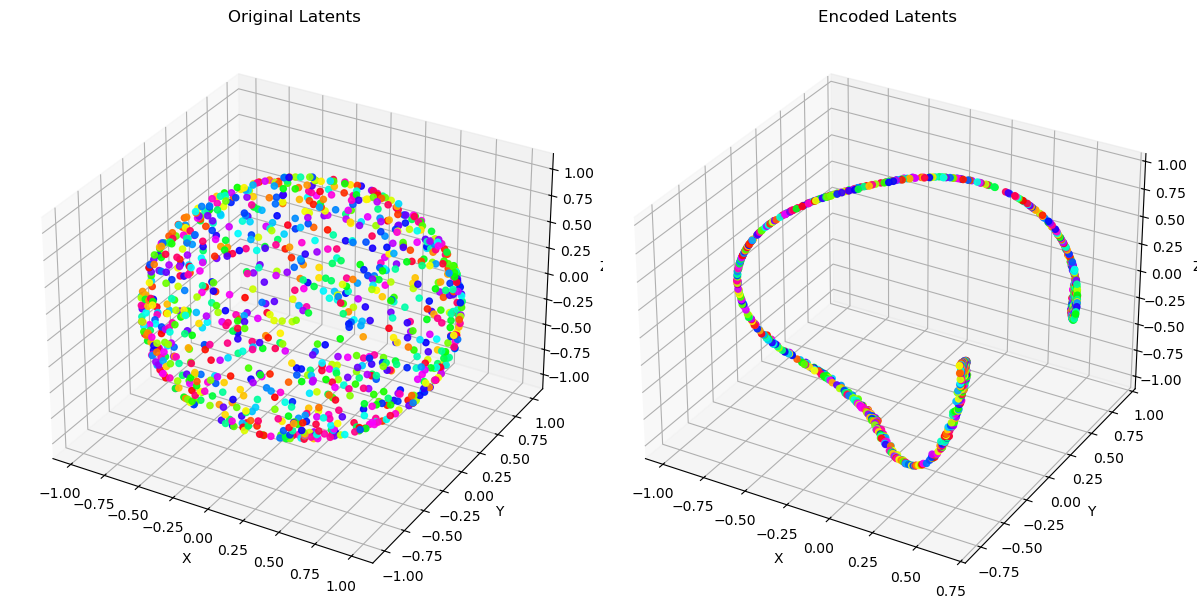

In [18]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    5, iterations , batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [19]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4838)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601300239562988 Samples processed: 1 linear disentanglement: 0.35996195673942566 permutation disentanglement: 0.0006044109468348324
Loss: 7.567330837249756 Samples processed: 21 linear disentanglement: 0.3759594261646271 permutation disentanglement: 0.038907188922166824
Loss: 7.504480838775635 Samples processed: 41 linear disentanglement: 0.3439662754535675 permutation disentanglement: 0.1988021284341812
Loss: 7.500273704528809 Samples processed: 61 linear disentanglement: 0.4074941575527191 permutation disentanglement: 0.1270267218351364
Loss: 7.496066570281982 Samples processed: 81 linear disentanglement: 0.4370501935482025 permutation disentanglement: 0.14623822271823883
Loss: 7.49216890335083 Samples processed: 101 linear disentanglement: 0.48705145716667175 permutation disentanglement: 0.19850754737854004
Loss: 7.485671520233154 Samples processed: 121 linear disentanglement: 0.5184369087219238 permutation disentangle

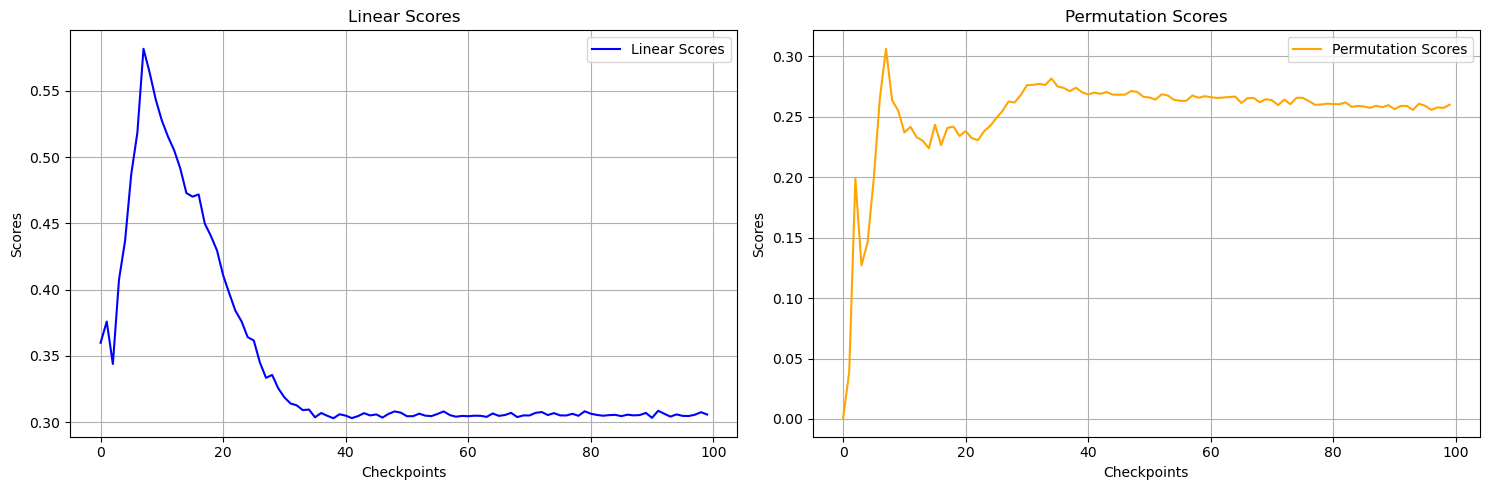

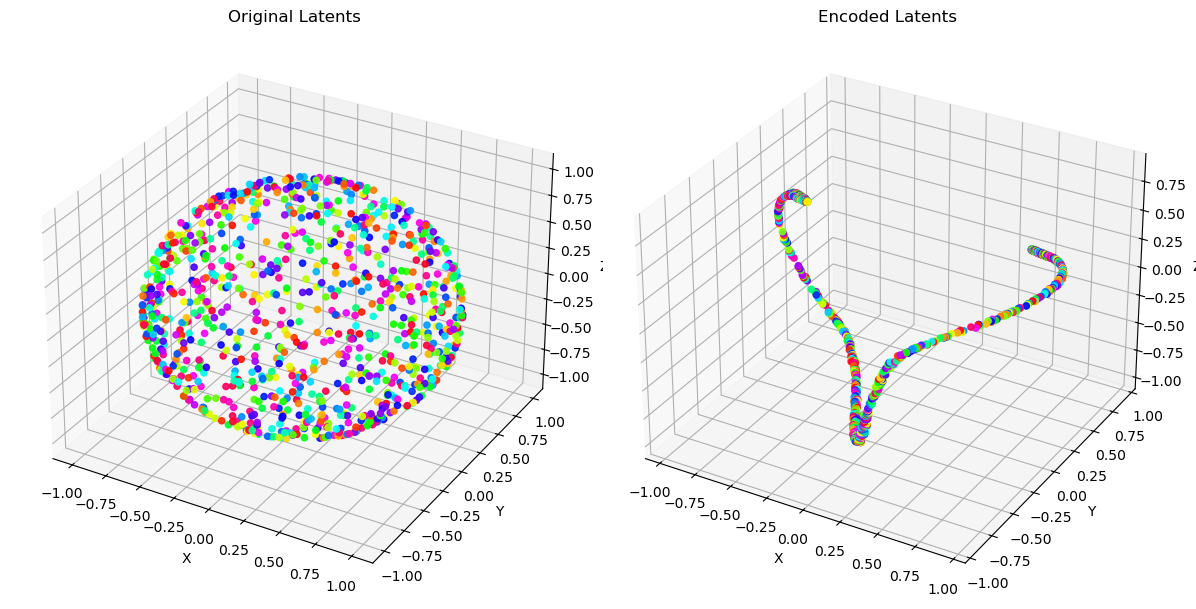

In [20]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [21]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4839)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601102828979492 Samples processed: 1 linear disentanglement: 0.5830846428871155 permutation disentanglement: 0.0012371540069580078
Loss: 7.526965141296387 Samples processed: 21 linear disentanglement: 0.545114278793335 permutation disentanglement: 0.2019641399383545
Loss: 7.491848945617676 Samples processed: 41 linear disentanglement: 0.404127836227417 permutation disentanglement: 0.24369031190872192
Loss: 7.485997676849365 Samples processed: 61 linear disentanglement: 0.44679442048072815 permutation disentanglement: 0.2569755017757416
Loss: 7.483558654785156 Samples processed: 81 linear disentanglement: 0.49229827523231506 permutation disentanglement: 0.3047906458377838
Loss: 7.482682704925537 Samples processed: 101 linear disentanglement: 0.5308672785758972 permutation disentanglement: 0.32231366634368896
Loss: 7.481971263885498 Samples processed: 121 linear disentanglement: 0.5553867220878601 permutation disentanglemen

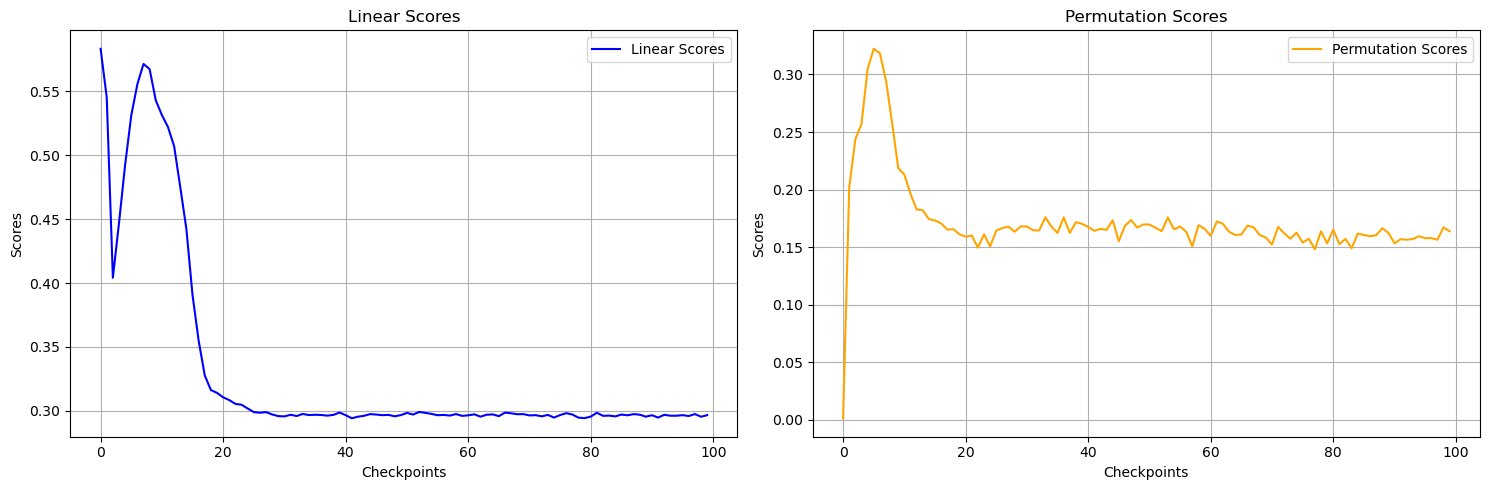

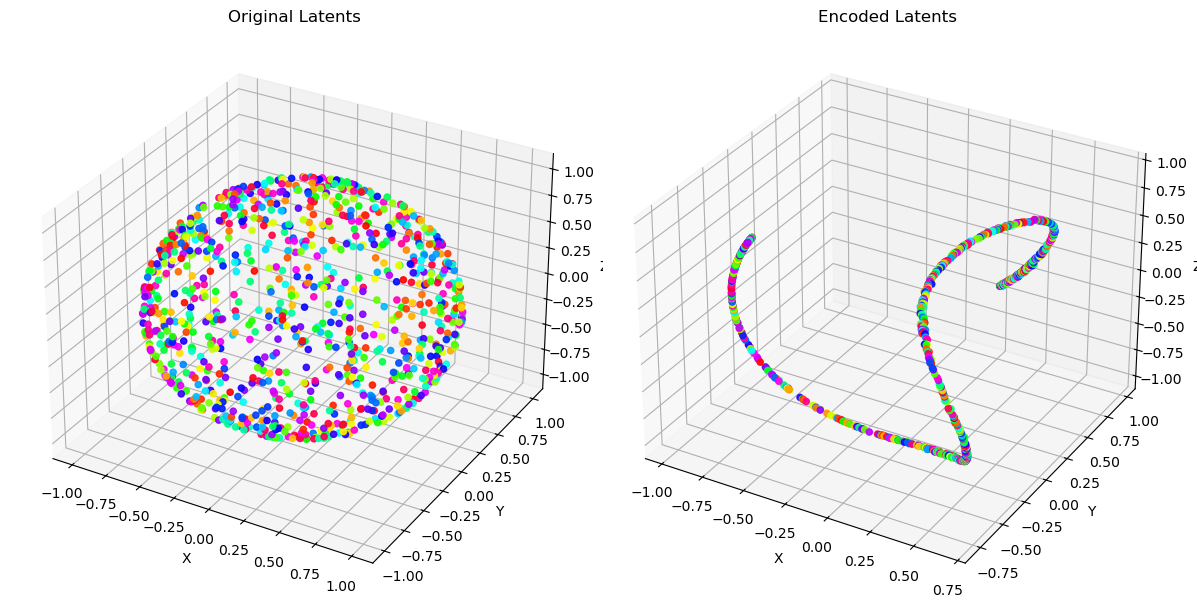

In [22]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [23]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4839)

## Spiral generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601391792297363 Samples processed: 1 linear disentanglement: 0.2702728509902954 permutation disentanglement: -0.00021990139794070274
Loss: 7.6009368896484375 Samples processed: 21 linear disentanglement: 0.3065316379070282 permutation disentanglement: 0.025369107723236084
Loss: 7.593743801116943 Samples processed: 41 linear disentanglement: 0.2641088366508484 permutation disentanglement: 0.05809374526143074
Loss: 7.54049825668335 Samples processed: 61 linear disentanglement: 0.2658824920654297 permutation disentanglement: 0.09133150428533554
Loss: 7.5248637199401855 Samples processed: 81 linear disentanglement: 0.29439041018486023 permutation disentanglement: 0.21425674855709076
Loss: 7.507203102111816 Samples processed: 101 linear disentanglement: 0.30467620491981506 permutation disentanglement: 0.24829243123531342
Loss: 7.505006313323975 Samples processed: 121 linear disentanglement: 0.3148128092288971 permutation disen

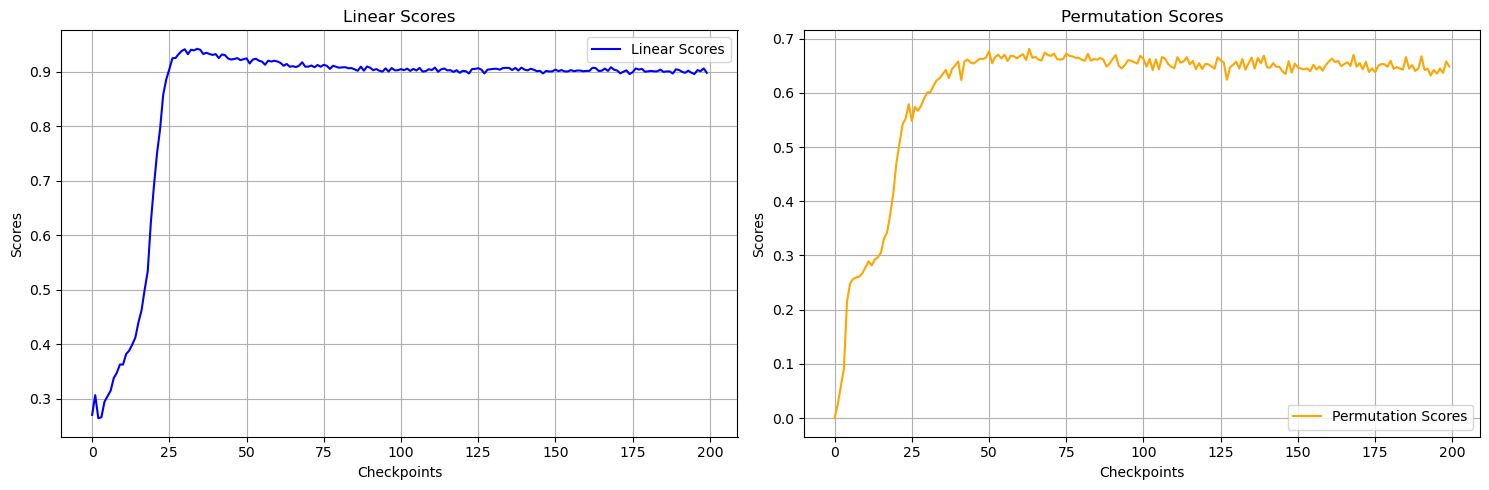

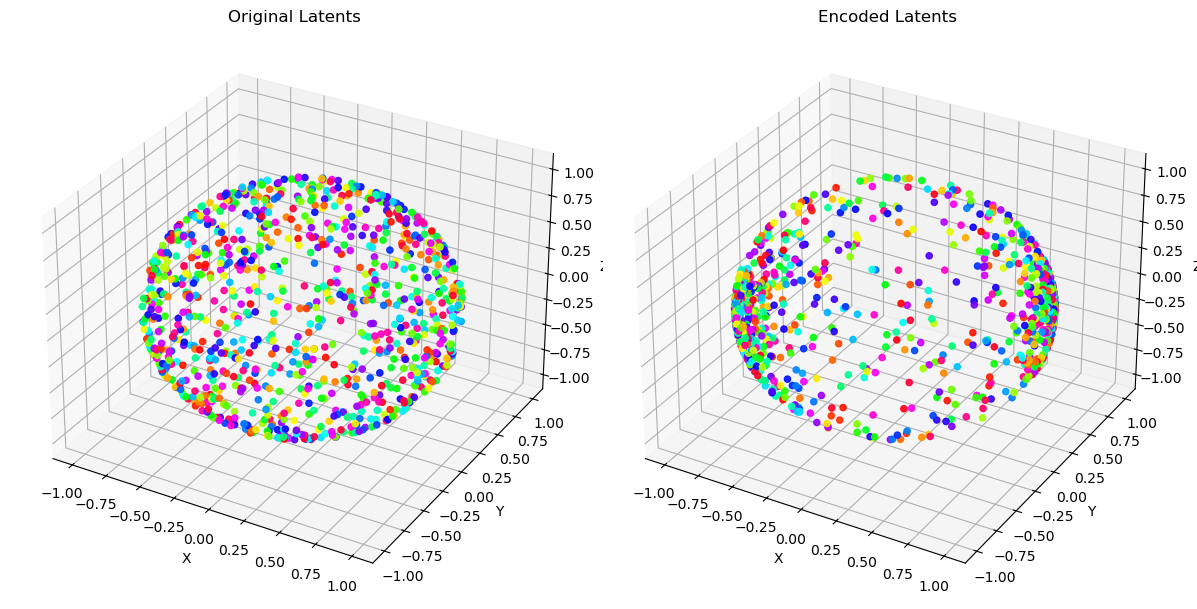

In [25]:
from data.generation import SpiralRotation

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

simclr_spiral = SimCLR(
    f_spiral, g_spiral, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_spiral, scores = simclr_spiral.train(batch_size, iterations * 2)

plot_scores(plt, scores)

h_spiral = lambda z: f_spiral(g_spiral(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_spiral(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [26]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4838)

## Patched generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601398944854736 Samples processed: 1 linear disentanglement: 0.3258953392505646 permutation disentanglement: 9.020169818541035e-05
Loss: 7.600908279418945 Samples processed: 21 linear disentanglement: 0.4685981273651123 permutation disentanglement: 0.000902156054507941
Loss: 7.594828128814697 Samples processed: 41 linear disentanglement: 0.47134268283843994 permutation disentanglement: 0.022552290931344032
Loss: 7.557961463928223 Samples processed: 61 linear disentanglement: 0.42286601662635803 permutation disentanglement: 0.04091944172978401
Loss: 7.5093255043029785 Samples processed: 81 linear disentanglement: 0.3058710992336273 permutation disentanglement: 0.10921051353216171
Loss: 7.507275581359863 Samples processed: 101 linear disentanglement: 0.29369378089904785 permutation disentanglement: 0.09029954671859741
Loss: 7.50600004196167 Samples processed: 121 linear disentanglement: 0.3238295018672943 permutation disent

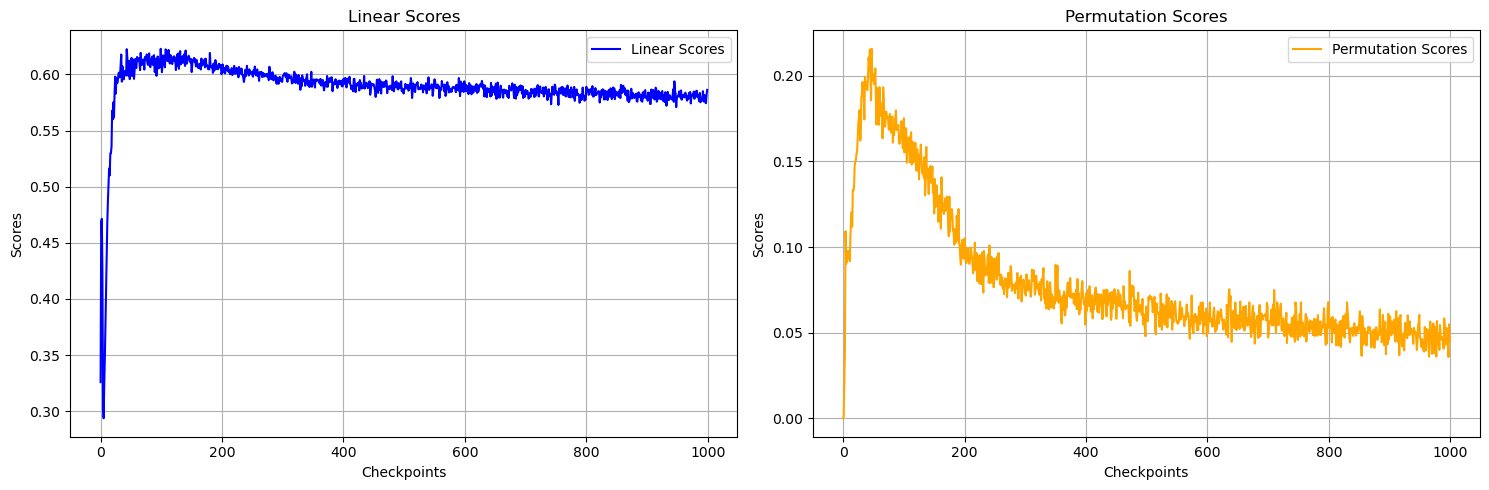

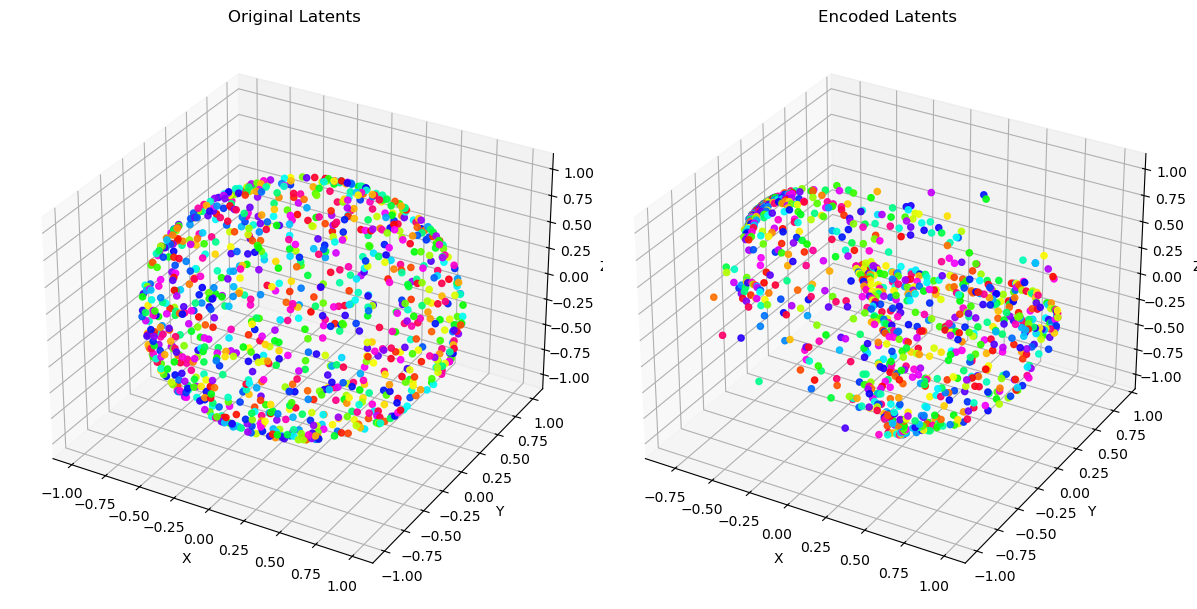

In [30]:
from data.generation import Patches

g_patches = Patches(5, device)
f_patches = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_patches = SimCLR(
    f_patches, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_patches, scores = simclr_patches.train(batch_size, iterations * 20)

plot_scores(plt, scores)

h_patches = lambda z: f_patches(g_patches(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_patches(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [10]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4838)

## Experiment with the invertible MLP as a data generating process

condition number threshold: 1.039983
layer 1/3,  condition number: 1.0182842121142552
layer 2/3,  condition number: 1.0386268837487342
layer 3/3,  condition number: 1.0358627764043027


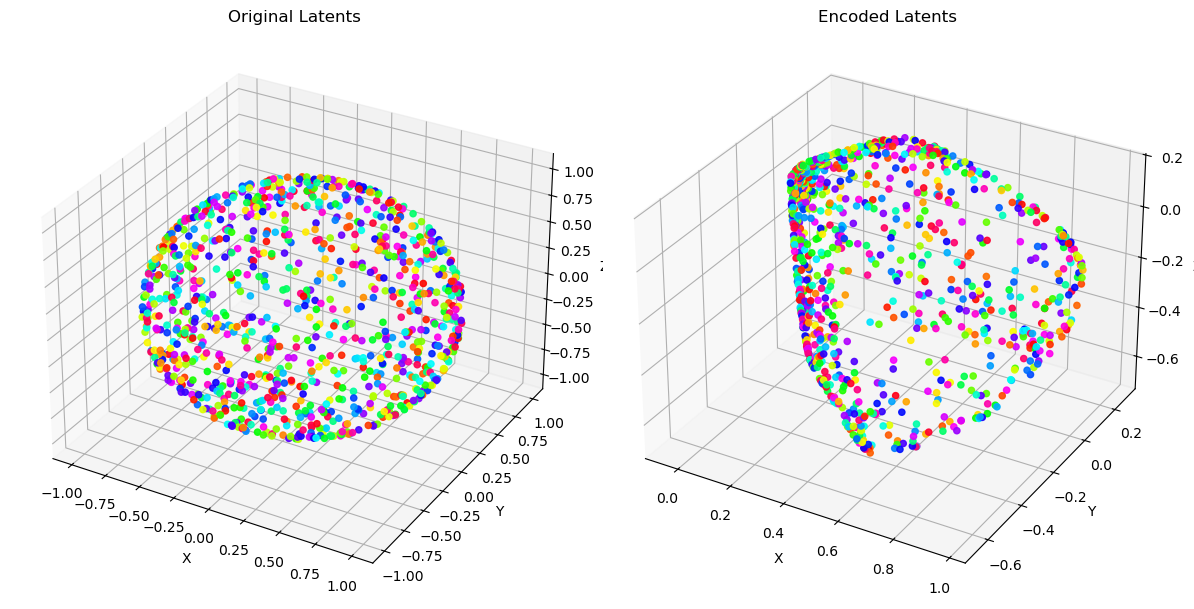

In [20]:
from invertible_network_utils import construct_invertible_mlp

g_mlp = construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct='leaky_relu',
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to(device)

z = full_sphere.uniform(1000).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), g_mlp(z).cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601395130157471 Samples processed: 1 linear disentanglement: 0.4863341748714447 permutation disentanglement: -1.1185805306013208e-05
Loss: 7.600617408752441 Samples processed: 21 linear disentanglement: 0.6039643883705139 permutation disentanglement: 0.001415292383171618
Loss: 7.591039657592773 Samples processed: 41 linear disentanglement: 0.577239453792572 permutation disentanglement: 0.04396573826670647
Loss: 7.544264793395996 Samples processed: 61 linear disentanglement: 0.4730253219604492 permutation disentanglement: 0.1619335412979126
Loss: 7.50425910949707 Samples processed: 81 linear disentanglement: 0.408063143491745 permutation disentanglement: 0.1492794156074524
Loss: 7.498875617980957 Samples processed: 101 linear disentanglement: 0.4186061918735504 permutation disentanglement: 0.1352265626192093
Loss: 7.49833869934082 Samples processed: 121 linear disentanglement: 0.41424068808555603 permutation disentanglemen

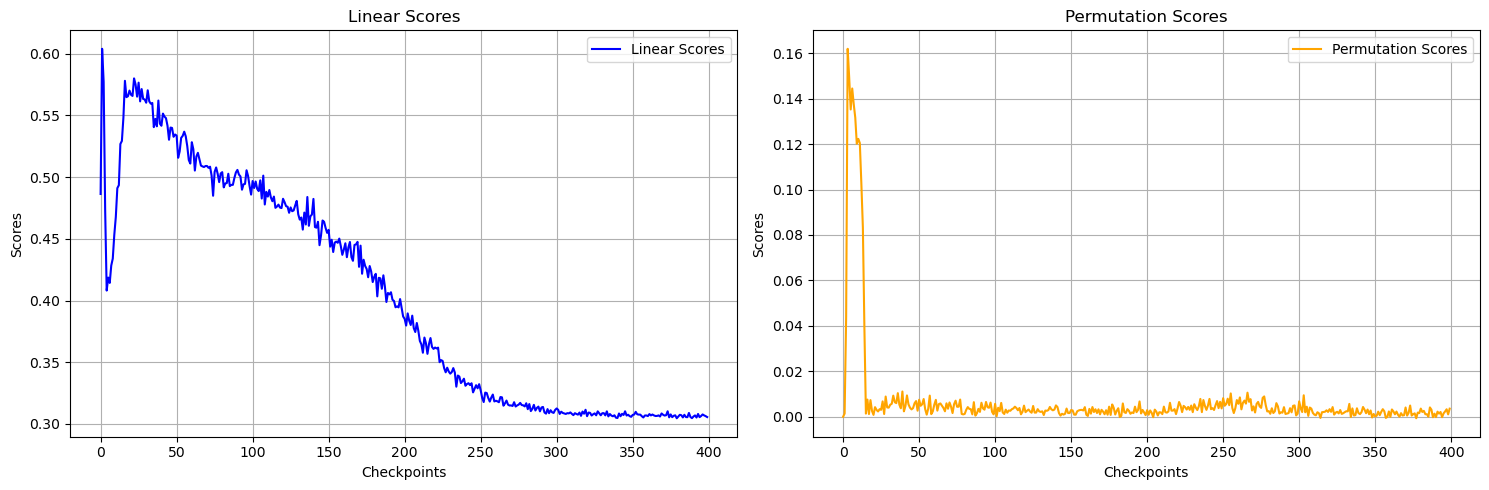

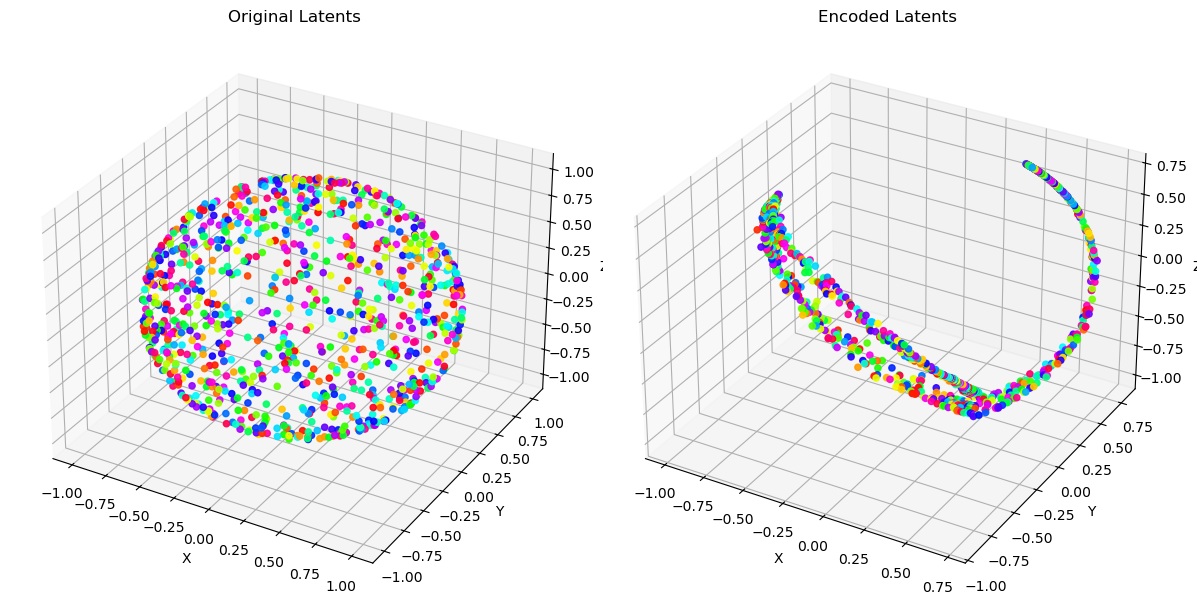

In [31]:
f_mlp = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_mlp = SimCLR(
    f_mlp, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_mlp, scores = simclr_mlp.train(batch_size, iterations * 4)

plot_scores(plt, scores)

h_mlp = lambda latent: f_mlp(g_mlp(latent))

z = full_sphere.uniform(1000).to(device)
z_enc = h_mlp(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [11]:
compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)

tensor(7.4840)

In [35]:
min([compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed) for _ in range(100)])

tensor(7.4834)

## Next

- Run it with a correct model (Cross-Entropy with a correct normalizer)